# Je passe à la partie préparation du Machine Learning

## 1) Importation des librairies

In [2]:
from pandas import DataFrame, read_json
import pandas as pd
import numpy as np
import re
import time
from datetime import *
import csv
import os

import pandas_profiling

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import random
random.seed(3)

In [4]:
insta_ml = pd.read_json('BACKUP/insta_avec_follower_final-BACKUP.json')

In [5]:
#POUR SAUVEGARDE pour Datavisualisation TABLEAU
insta_ml.to_csv('BACKUP/insta_avec_follower_final-BACKUP.csv', index=False)
    #Enregistrer ce fichier de script

In [6]:
insta_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23273 entries, 0 to 23272
Data columns (total 29 columns):
page_id                         23273 non-null int64
page_username                   23273 non-null object
date_time                       23273 non-null datetime64[ns]
date                            23273 non-null datetime64[ns]
code_jour_semaine               23273 non-null int64
day                             23273 non-null int64
month                           23273 non-null int64
year                            23273 non-null int64
time                            23273 non-null object
publication_id                  23273 non-null int64
publication_type                23273 non-null object
text_publication                23273 non-null object
publication_liked_count         23273 non-null int64
publication_height              23273 non-null int64
publication_width               23273 non-null int64
publication_url                 23273 non-null object
publication_comment_

In [7]:
insta_ml.head(3)

page_id              page_username           date_time       date  \
0  4741863243  librairielestempsmodernes 2017-03-09 22:16:32 2017-03-09   
1  4741863243  librairielestempsmodernes 2017-03-01 20:16:30 2017-03-01   
2  3655964171         librairielibellule 2019-10-11 16:56:30 2019-10-11   

   code_jour_semaine  day  month  year      time       publication_id  ...  \
0                  4    9      3  2017  22:16:32  1466950865096294144  ...   
1                  3    1      3  2017  20:16:30  1461092250598961920  ...   
2                  5   11     10  2019  16:56:30  2152397435142459904  ...   

  publication_shortcode                          publication_thumbnail_src  \
0           BRbqAohBD9A  https://scontent-cdt1-1.cdninstagram.com/vp/5b...   
1           BRG16klBvN5  https://scontent-cdt1-1.cdninstagram.com/vp/bc...   
2           B3e2hA5INJC  https://scontent-cdt1-1.cdninstagram.com/vp/cb...   

                                        hashtag_list  hashtag_list_count  \
0                                     pas de hashtag                   0   
1                                     pas de hashtag                   0   
2  [#librairie, #libellule, #librairieLibellule, ...                  21   

                               publication_word_list  \
0                                                      
1                                                      
2  [On, est, dans, la, place, au, Salon, "Lire, e...   

  publication_word_list_count  hour  week_weekend  page_nb_followers edi_lib  
0                           0    22             0                218       1  
1                           0    20             0                218       1  
2                          41    16             0                236       1  

[3 rows x 29 columns]

## 2) Analyse statistique des variables numériques
**A noter** : Je supprime les Id des comptes et publications qui ne serviront pas à prédire le nombre de like. <br/> Les Date/datetime ont été découpés en day/month/year/hour/code jour mais je choisis de ne conserver que les colonnes `code_jour_semaine` et `hour` pour la suite du travail et supprime les autres colonnes.<br/>
Je retire également les colonnes `publication_video_view_count` et `publication_comment_count` qui sont des informations postérieures à la publication et donc sont un résultat de la publication tout comme l'est le nombre de like.

In [8]:
insta_ml_num = insta_ml.select_dtypes(include=['int64','float64','datetime64[ns]']).drop(columns=['publication_id','page_id','date_time','date','publication_video_view_count','year','month','day','publication_comment_count'])
insta_ml_num_describe = insta_ml_num.describe().T
insta_ml_num_describe['null'] = [insta_ml_num[column].isnull().sum() for column in insta_ml_num_describe.index]
insta_ml_num_describe

count         mean           std    min  \
code_jour_semaine            23273.0     3.815795      1.766579    1.0   
publication_liked_count      23273.0   121.053066    324.104156    0.0   
publication_height           23273.0  1020.172131    219.487253  166.0   
publication_width            23273.0  1011.138401    160.662926  320.0   
hashtag_list_count           23273.0     7.847248      6.900461    0.0   
publication_word_list_count  23273.0    51.624586     56.647929    0.0   
hour                         23273.0    14.448245      4.054596    0.0   
week_weekend                 23273.0     0.197439      0.398075    0.0   
page_nb_followers            23273.0  5053.062132  12561.795879   14.0   
edi_lib                      23273.0     0.404933      0.490890    0.0   

                                25%     50%     75%       max  null  
code_jour_semaine               2.0     4.0     5.0       7.0     0  
publication_liked_count        21.0    41.0    93.0   19170.0     0  
publication_height            970.0  1080.0  1080.0    1921.0     0  
publication_width            1080.0  1080.0  1080.0    1080.0     0  
hashtag_list_count              3.0     7.0    11.0      55.0     0  
publication_word_list_count    17.0    33.0    64.0     420.0     0  
hour                           11.0    15.0    18.0      23.0     0  
week_weekend                    0.0     0.0     0.0       1.0     0  
page_nb_followers             423.0  1180.0  2902.0  116483.0     0  
edi_lib                         0.0     0.0     1.0       1.0     0

### Graphiques de distribution

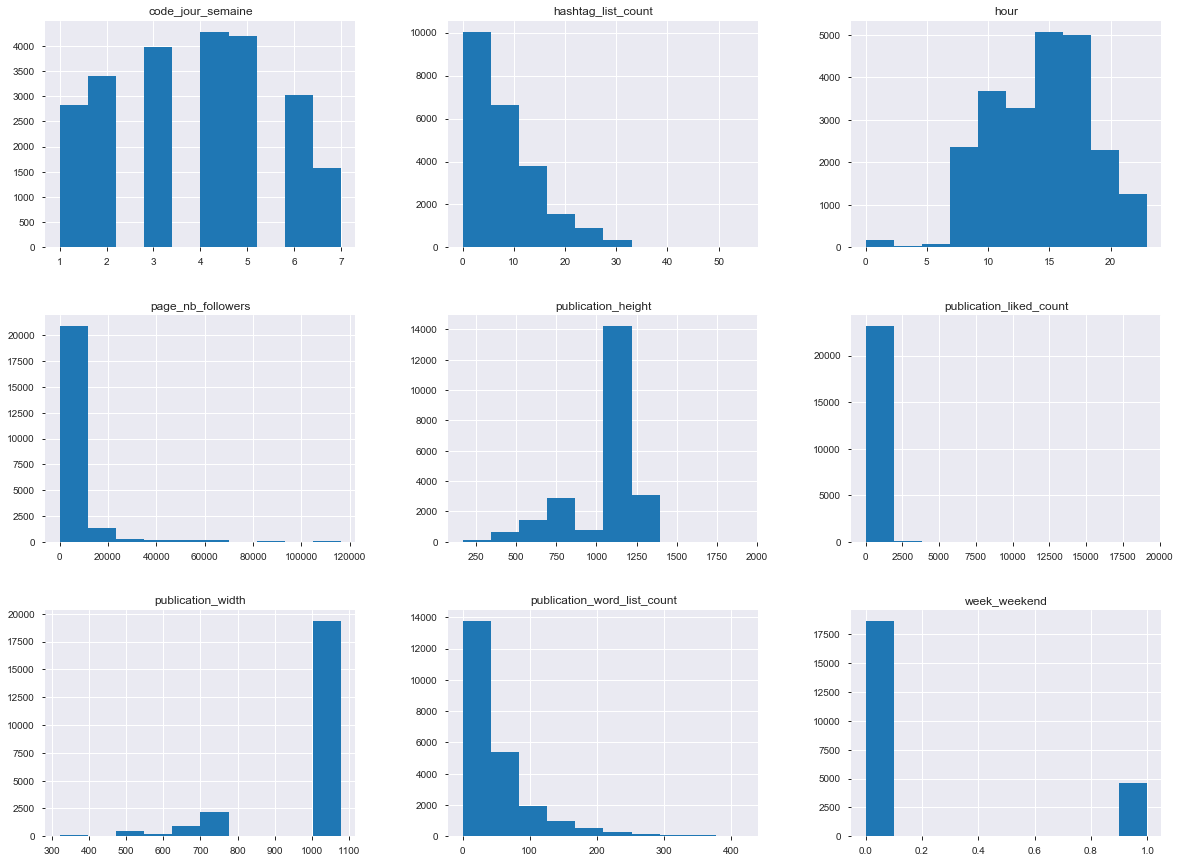

In [9]:
insta_ml[['code_jour_semaine','hour','publication_liked_count','publication_height','publication_width','hashtag_list_count','publication_word_list_count','week_weekend','page_nb_followers']].hist(figsize=(20,15))
plt.show()

**Note** : A l'analyse de ces données statistiques, je choisis de calculer le log pour la colonne `page_nb_followers` car cette variable a une trop forte variance.

## 3) Log de la colonne `page_nb_followers`

In [10]:
insta_ml_log = insta_ml.copy()
insta_ml_log[['page_nb_followers_log']]=insta_ml_log[['page_nb_followers']].apply(lambda x: np.log(x+1))

In [11]:
insta_ml_num = insta_ml_log.select_dtypes(include=['int64','float64','datetime64[ns]']).drop(columns=['page_nb_followers','publication_id','page_id','date_time','date','publication_video_view_count','year','month','day','publication_comment_count'])

insta_ml_num.describe().T

count         mean         std        min  \
code_jour_semaine            23273.0     3.815795    1.766579    1.00000   
publication_liked_count      23273.0   121.053066  324.104156    0.00000   
publication_height           23273.0  1020.172131  219.487253  166.00000   
publication_width            23273.0  1011.138401  160.662926  320.00000   
hashtag_list_count           23273.0     7.847248    6.900461    0.00000   
publication_word_list_count  23273.0    51.624586   56.647929    0.00000   
hour                         23273.0    14.448245    4.054596    0.00000   
week_weekend                 23273.0     0.197439    0.398075    0.00000   
edi_lib                      23273.0     0.404933    0.490890    0.00000   
page_nb_followers_log        23273.0     7.172471    1.552458    2.70805   

                                     25%          50%        75%           max  
code_jour_semaine               2.000000     4.000000     5.0000      7.000000  
publication_liked_count        21.000000    41.000000    93.0000  19170.000000  
publication_height            970.000000  1080.000000  1080.0000   1921.000000  
publication_width            1080.000000  1080.000000  1080.0000   1080.000000  
hashtag_list_count              3.000000     7.000000    11.0000     55.000000  
publication_word_list_count    17.000000    33.000000    64.0000    420.000000  
hour                           11.000000    15.000000    18.0000     23.000000  
week_weekend                    0.000000     0.000000     0.0000      1.000000  
edi_lib                         0.000000     0.000000     1.0000      1.000000  
page_nb_followers_log           6.049733     7.074117     7.9735     11.665509

In [12]:
import plotly.express as px
fig = px.box(insta_ml_log, y="page_nb_followers_log")
fig.show()

In [13]:
insta_ml_log.shape

(23273, 30)

## 4) Analyse des variables catégorielles

In [14]:
insta_ml_cat = insta_ml.select_dtypes(include=['object','category']).drop(columns=['time'])
insta_ml_cat_describe = insta_ml_cat.describe().T
insta_ml_cat_describe

count unique  \
page_username              23273   1150   
publication_type           23273      3   
text_publication           23273  22477   
publication_url            23273  23273   
publication_shortcode      23273  23273   
publication_thumbnail_src  23273  23273   
hashtag_list               23273  17751   
publication_word_list      23273  22082   

                                                                         top  \
page_username                                                  bdnetbastille   
publication_type                                                       Image   
text_publication                                                Pas de texte   
publication_url            https://scontent-cdt1-1.cdninstagram.com/vp/62...   
publication_shortcode                                            BxjjKeroM-N   
publication_thumbnail_src  https://scontent-cdt1-1.cdninstagram.com/vp/2b...   
hashtag_list                                                  pas de hashtag   
publication_word_list                                                          

                            freq  
page_username                 90  
publication_type           17575  
text_publication             367  
publication_url                1  
publication_shortcode          1  
publication_thumbnail_src      1  
hashtag_list                4128  
publication_word_list        367

## 5) Data Analytics

### 5.1) Répartition des publications par format

In [15]:
bubble = insta_ml.groupby('publication_type').agg({'publication_type': 'count', 'publication_liked_count': 'mean'})
bubble.rename(columns={'publication_type':'nombre_publication','publication_liked_count':'nb_like_moyen'},inplace=True)
bubble = bubble.assign(pourcentage_publication=bubble['nombre_publication'].apply(lambda p : str(int(p/bubble['nombre_publication'].sum()*100))+'%'))
bubble['nb_like_moyen'] = bubble['nb_like_moyen'].map(lambda like : int(like))
bubble =bubble[['nombre_publication','pourcentage_publication','nb_like_moyen']]
bubble

nombre_publication pourcentage_publication  nb_like_moyen
publication_type                                                           
Image                          17575                     75%            120
Sidecar                         4494                     19%            127
Video                           1204                      5%            114

In [16]:
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
init_notebook_mode()

trace0 = Scatter(
    x=[i for i in bubble.index],
    y=[p for p in bubble.nombre_publication],
    mode='markers+text', 
    text=[(pct,nb) for pct,nb in zip(bubble['pourcentage_publication'],bubble['nb_like_moyen'])],
    textposition="top center",
    marker=dict(size=[p/100 for p in bubble.nombre_publication],color=[p for p in bubble.nombre_publication],
        showscale=True))


data = [trace0]
layout = Layout(
    showlegend=False,
    height=600,
    width=900,title='Pourcentage des publications et nombre moyen de like par format',)

fig = dict( data=data, layout=layout )

iplot(fig)  

### 5.2) Répartition des publications par heure avec distinction des tranches horaires

In [17]:
def bin_f(x):
    my_date = pd.to_datetime(x, format='%H')
    return my_date

In [18]:
hour_graph = insta_ml.groupby('hour').agg({'hour': 'count', 'publication_liked_count': 'mean'})
hour_graph.rename(columns={'hour':'nb_publication','publication_liked_count':'nb_like_moyen'},inplace=True)
hour_graph=hour_graph.assign(hour=[int(h) for h in hour_graph.index])

hour_graph = hour_graph.assign(tranche_horaire=hour_graph['hour'].map(lambda h: '0_11' if int(bin_f(h).hour) < 11 else (
    '11_15' if int(bin_f(h).hour) < 15 else ('15_18' if int(bin_f(h).hour) < 18 else '18_23'))))

hour_graph.drop(columns=['hour'],inplace=True)

hour_graph['nb_like_moyen'] = hour_graph['nb_like_moyen'].map(lambda like : int(like))

hour_graph.head(3)

nb_publication  nb_like_moyen tranche_horaire
hour                                               
0                 99             52            0_11
1                 59             39            0_11
2                 24             56            0_11

In [19]:
ax3=insta_ml[['hour','publication_liked_count']].copy()
ax3 = ax3.assign(tranche_horaire=ax3['hour'].map(lambda h: '0_11' if int(bin_f(h).hour) < 11 else (
    '11_15' if int(bin_f(h).hour) < 15 else ('15_18' if int(bin_f(h).hour) < 18 else '18_23'))))
ax3group =ax3.groupby('tranche_horaire').agg({'publication_liked_count': 'mean'})
tranche = [str(i) for i in ax3group.index]
moy_like = [str(int(j)) for j in ax3group['publication_liked_count']]

labels = [(i,'Nb moyen like = '+ j) for i,j in zip(tranche,moy_like)]
labels

[('0_11', 'Nb moyen like = 107'),
 ('11_15', 'Nb moyen like = 104'),
 ('15_18', 'Nb moyen like = 115'),
 ('18_23', 'Nb moyen like = 153')]

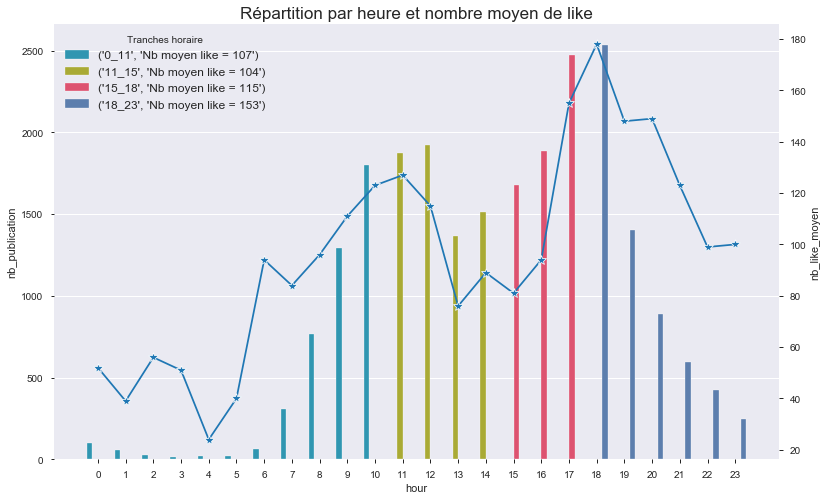

In [20]:
fig,ax= plt.subplots(figsize=(13,8))
sns.set_style("white", {'axes.grid' : False})

flatui = ["#1BA3C6", "#BCBD22", "#F43C63", "#4F7CBA"]

g = sns.barplot(data=hour_graph, x=hour_graph.index, y='nb_publication', hue= 'tranche_horaire',ax=ax, palette=flatui)
ax2 = ax.twinx()
g = sns.lineplot(x=hour_graph.index,  y='nb_like_moyen', data=hour_graph, ax=ax2, marker='*', markersize=10)

h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, title="Tranches horaire", fontsize=12)

ax.set_title('Répartition par heure et nombre moyen de like', fontsize = 17)
plt.show()



## 6) Martice de corrélation des colonnes numériques

Pour supprimer d'éventuelles colonnes qui auraient un effet sur le modèle.

In [21]:
insta_ml_num_corr = insta_ml_num.corr()

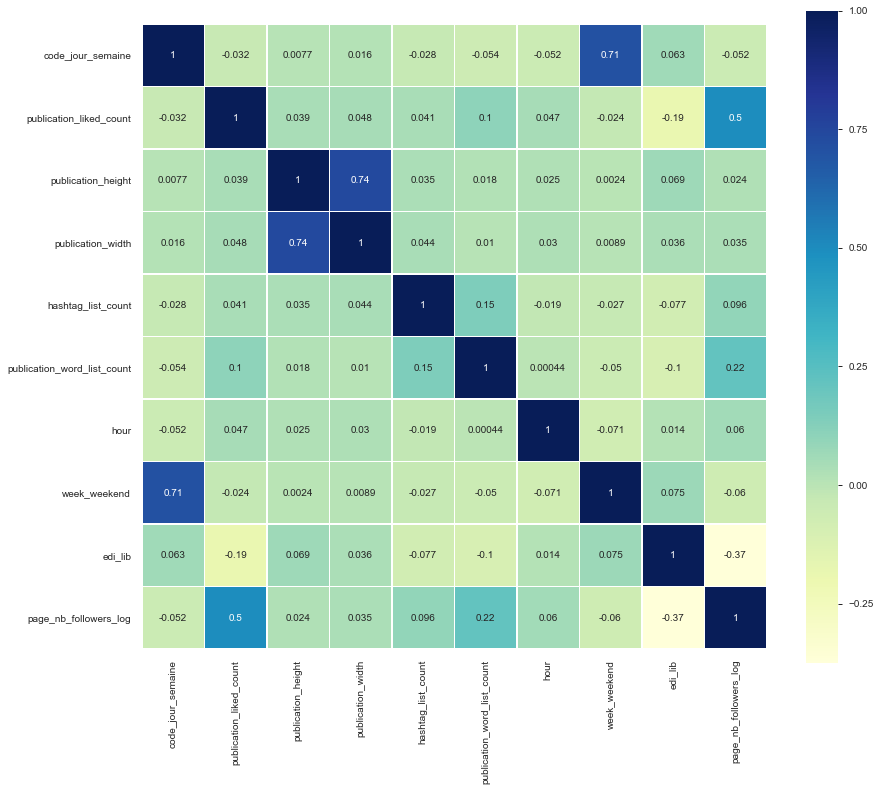

In [22]:
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(14, 12))

# Generate a custom diverging colormap #
cmap="YlGnBu"

# Draw the heatmap with the mask and correct aspect ratio (mask=mask)
ax = sns.heatmap(insta_ml_num_corr, cmap=cmap, annot=True, annot_kws={"size": 10},square=True, linewidths=.5)

#### Note : 
- il y a une forte corrélation entre les variables `week_weekend` et `code_jour_semaine` mais ceci est normal puisque les codes 6 et 7 sont liées au weekend et le restant des jours à la semaine (week)

Regardons de plus près les coefficients de corrélation de la target publication_liked_count aka le nombre de like pour une publication.

In [23]:
insta_ml_num_corr['publication_liked_count'].sort_values(ascending=False)

publication_liked_count        1.000000
page_nb_followers_log          0.496264
publication_word_list_count    0.104775
publication_width              0.048080
hour                           0.046769
hashtag_list_count             0.041036
publication_height             0.038913
week_weekend                  -0.023608
code_jour_semaine             -0.031972
edi_lib                       -0.186804
Name: publication_liked_count, dtype: float64

#### Note : 
- On observe une corrélation entre le nombre de likes pour une publication et le nombre de followers d'un compte.  --> on pourrait par exemple avancer l'hypothèse que plus on a de personnes qui suivent un compte plus ce dernier aura de like à ses publications.
- il y a une faible corrélation négative en le fait d'être un libraire ou un éditeur et le nb de like. donc le fait d'être l'un ou l'autre n'aurait pas d'influence sur le nb de likes. 

## 7) Séparation des variables en Features et Target
- y = la target : est le nombre de like pour une publication.
- X = les variables retenues : les infos de temporalité (date, jour de la semaine, semaine/weekend, heure), le nombre de commentaires, le type de publication, la taille de la publication, le nombre de mots dans une publication, le nombre de hashtag, le nombre de vue si la publication est une vidéo, s'il s'agit d'un éditeur ou une librairie, le nombre de fans du compte. 

In [24]:
# y pour la Target
y= insta_ml_log["publication_liked_count"]
y=y.apply(lambda x: np.log(x+1)) #car y.min()=0

# X pour les Features - 9 variables explicatives
X=insta_ml_log[['code_jour_semaine', 'hour', 'publication_type', 'publication_height',
                   'publication_is_video', 'hashtag_list_count', 'publication_word_list_count', 
                   'page_nb_followers_log','edi_lib']] 

# je supprime les features suivantes après un essai avec qui va vers un over-fitting : 'publication_width','week_weekend', 

**Note** : 
- Pour la variable catégorielle `publication_type`, je vais utiliser la méthode get.dummies pour obtenir 3 colonnes numérique.
- pour la variable `publication_is_video`, il s'agit d'une variable de type boléen. Je la transforme en 0 pour False et 1 pour True. 

### 7.1) publication_is_video

In [25]:
X['publication_is_video'] = np.where(X['publication_is_video']==True,1,0)

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23273 entries, 0 to 23272
Data columns (total 9 columns):
code_jour_semaine              23273 non-null int64
hour                           23273 non-null int64
publication_type               23273 non-null object
publication_height             23273 non-null int64
publication_is_video           23273 non-null int64
hashtag_list_count             23273 non-null int64
publication_word_list_count    23273 non-null int64
page_nb_followers_log          23273 non-null float64
edi_lib                        23273 non-null int64
dtypes: float64(1), int64(7), object(1)
memory usage: 1.6+ MB


### 7.2) publication_type
Utilisation de la fonction get.dummies

In [27]:
X = pd.get_dummies(X)

In [28]:
X.drop(columns='publication_type_Video', inplace=True)

In [29]:
X.shape, y.shape

((23273, 10), (23273,))

## 8) Split des données en training (80%) et testing (20%) .
Je réalise un split classique de type 80% pour le training et 20% pour le test.

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y ,train_size=0.80, test_size=0.20)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18618, 10), (4655, 10), (18618,), (4655,))

## 9) Sélection du modèle via la Cross-Validation

Je décide de passer par la méthode de cross-validation pour choisir mon modèle de prédiction. <br/>

La validation croisée en français est une méthode qui permet d'estimer les performances de généralisation de plusieurs modèles à partir de l’ensemble d’apprentissage. Cette estimation pourra être comparée à l’estimation obtenue sur l’ensemble de test mis de côté au départ. <br/>

La cross validation consiste à recommencer sur plusieurs découpages train/test différents du jeu de données initial de manière à s’assurer que la prédiction est stable et éviter d'overfitting.

In [31]:
from sklearn import metrics

#print('Liste des scores existants dans le module sklearn:\n\n',metrics.SCORERS.keys())

from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor

regressors = {'K-Nearest Neighbor': KNeighborsRegressor(n_neighbors=3),
              'Decision Tree': DecisionTreeRegressor(),
              'Ridge Regression': Ridge(),
              'Random Forest': RandomForestRegressor(),
              'Gradient Boosting': GradientBoostingRegressor(), 
              'AdaBoost': AdaBoostRegressor(),
              'Bagging Regressor': BaggingRegressor(),
              'Linear Regression': LinearRegression(),
              'XGB Regressor':XGBRegressor(objective ='reg:squarederror')}

def compare_models(x, y, model_dict, folds=3):
    results = []
    
    for name, model in model_dict.items():
        scores = cross_val_score(model, x, y, cv=folds, scoring='r2')
        stats = [name, scores.mean()*100, min(scores), max(scores), scores.std(), pd.Series(scores).mad()]
        results.append(stats)
        print(model)
    
    df = pd.DataFrame(results, columns = ['Model', 'Mean', 'Min', 'Max','Std', 'Mad'])
    df = df.sort_values('Mean', ascending = False)
    return df

compare_models(X_train, y_train, regressors, 10)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will chan

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=N

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


Model       Mean       Min       Max       Std       Mad
3       Random Forest  77.099306  0.742490  0.783751  0.012489  0.009794
6   Bagging Regressor  77.090864  0.748421  0.787427  0.011838  0.009658
4   Gradient Boosting  72.769696  0.697914  0.750937  0.014133  0.011223
8       XGB Regressor  72.729981  0.698563  0.750518  0.014065  0.011495
2    Ridge Regression  68.406413  0.655149  0.708757  0.013032  0.009310
7   Linear Regression  68.406391  0.655142  0.708756  0.013034  0.009312
5            AdaBoost  59.668860  0.560612  0.629102  0.021804  0.019576
1       Decision Tree  59.207709  0.534645  0.635184  0.033377  0.028008
0  K-Nearest Neighbor  34.554129  0.291033  0.396742  0.031989  0.025269

## 10) Grid Search pour le XGBoost, Gradient Boosting, Bagging Regressor et Random Forest 
J'ai choisi de faire d'appliquer la méthode de Grid search sur les modèles ayant la meilleur moyenne de r2_score. 

In [32]:
%%time
from sklearn.model_selection import GridSearchCV

#XGBoost

model_xgb = XGBRegressor(objective ='reg:squarederror')
grid_param_xgb = {"n_estimators":[50,100,150],
                 "learning_rate"    : [0.05, 0.10, 0.15] ,
                 "max_depth"        : [3,5,6,7], #4,5,10,20, 50, 100,200,500
                 "min_child_weight" : [1,3]
                 }
grid_xgb=GridSearchCV(model_xgb,grid_param_xgb,cv=5)

#Ajout de Random Forest après suppression de features 

model_rfr = RandomForestRegressor() 
grid_param_rfr = { 
            #"n_estimators": [10,20,30],
            "max_features": ["auto", "sqrt", "log2"],
            "max_depth": [3,5,10,None],
            'bootstrap':[True, False]}
grid_rfr=GridSearchCV(model_rfr,grid_param_rfr,cv=5)


#Gradient Boosting

model_gbr = GradientBoostingRegressor()
grid_param_gbr = {"max_depth": [1,2,3],
                  'n_estimators': [50,100,150],
                  "loss":['ls', 'lad', 'huber', 'quantile'],
                  "max_features":['auto', 'sqrt', 'log2',None]}
grid_gradient=GridSearchCV(model_gbr,grid_param_gbr,cv=5)


#Bagging Regressor

model_bg = BaggingRegressor()
grid_param_bg = {"n_estimators": [5,10,20,50],
                 "max_features":[1,2,3,4,5],
                 "bootstrap": [True, False],
                 "bootstrap_features": [True, False]
                }
grid_bagging=GridSearchCV(model_bg,grid_param_bg,cv=5)

grid_model_list={'gradient':grid_gradient,
                 'bagging':grid_bagging,
                'random_forest':grid_rfr,
                 'xgboost':grid_xgb}


def grid_models(x, y, grid_dict):
    for name, model in grid_dict.items(): 
        model.fit(X_train,y_train)
        print(name)
        print(model.best_score_)
        print(model.best_params_)

grid_models(X_train, y_train, grid_model_list)

gradient
0.7339835080333355
{'loss': 'ls', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 150}
bagging
0.6935689516981102
{'bootstrap': False, 'bootstrap_features': False, 'max_features': 5, 'n_estimators': 10}


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will chan

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will chan

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will chan

random_forest
0.7643480245506482
{'bootstrap': True, 'max_depth': None, 'max_features': 'auto'}


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version


xgboost
0.7818191770011003
{'learning_rate': 0.15, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 150}
CPU times: user 12min 29s, sys: 6.71 s, total: 12min 36s
Wall time: 12min 38s


## 11) Cross Validation pour les 4 modèles retenus et les paramètres retenus 

In [33]:
%%time
"""
gradient
0.7339835080333355
{'loss': 'ls', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 150}
bagging
0.6935689516981102
{'bootstrap': False, 'bootstrap_features': False, 'max_features': 5, 'n_estimators': 10}
random_forest
0.7643480245506482
{'bootstrap': True, 'max_depth': None, 'max_features': 'auto'}
xgboost
0.7818191770011003
{'learning_rate': 0.15, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 150}
"""

regressors2 = {
            'Gradient Boosting': GradientBoostingRegressor(loss= 'ls',max_depth= 3, max_features= 'auto', n_estimators= 150), 
            'Bagging Regressor': BaggingRegressor(bootstrap= False, bootstrap_features= False, max_features= 5, n_estimators= 10),
            'RF Regressor_grid':RandomForestRegressor(bootstrap=True, max_depth=None, max_features= 'auto'),#, min_samples_split= 8, n_estimators= 30
            'XGB Regressor_grid': XGBRegressor(objective ='reg:squarederror', learning_rate=0.15, max_depth= 7,min_child_weight= 1,n_estimators = 150)}#,n_estimators= 100, min_child_weight=5,

def compare_models_tuned(x, y, model_dict, folds=3):
    results = []
    
    for name, model in model_dict.items():
        scores = cross_val_score(model, x, y, cv=folds, scoring='r2')
        stats = [name, scores.mean()*100, min(scores), max(scores), scores.std(), pd.Series(scores).mad()]
        results.append(stats)
    
    df = pd.DataFrame(results, columns = ['Model', 'Mean', 'Min', 'Max','Std', 'Mad'])
    df = df.sort_values('Mean', ascending = False)
    return df

compare_models_tuned(X_train, y_train, regressors2, 5)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a fut

CPU times: user 15.9 s, sys: 120 ms, total: 16.1 s
Wall time: 16.1 s


Model       Mean       Min       Max       Std       Mad
3  XGB Regressor_grid  78.181934  0.775991  0.788672  0.004708  0.004202
2   RF Regressor_grid  76.264320  0.753880  0.772806  0.008211  0.007914
0   Gradient Boosting  73.398347  0.724960  0.741862  0.005727  0.004692
1   Bagging Regressor  68.126199  0.591730  0.727472  0.046936  0.035813

## 12) Je retiens donc le modèle xgboost

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

#X_test.drop(columns=['label', 'prediction'], inplace=True)
# suite à Grid 17h20 = xgb_reg = XGBRegressor(objective ='reg:squarederror', learning_rate=0.15, max_depth= 4,n_estimators= 500, min_child_weight=2)#,n_estimators= 100, min_child_weight=5,

xgb_reg = XGBRegressor(objective ='reg:squarederror', learning_rate=0.15, 
                       max_depth= 7,min_child_weight= 1,n_estimators = 150)
# fitting the model
xgb_reg.fit(X_train, y_train)

# predict the response
y_test_predict_xgb_reg = xgb_reg.predict(X_test)


R2_test =  round(r2_score(y_test, y_test_predict_xgb_reg),2)*100
R2_train = round(r2_score(y_train, xgb_reg.predict(X_train)),2)*100 
print('\nR2_score_train', R2_train, '\nR2_score_test', R2_test)

rmsle_test = np.sqrt(mean_squared_error(y_test, y_test_predict_xgb_reg))
rmsle_train = np.sqrt(mean_squared_error(y_train, xgb_reg.predict(X_train)))
print('\nrmse_score_train', rmsle_train, '\nrmse_score_test', rmsle_test)

real_rmse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_test_predict_xgb_reg)))
real_rmse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(xgb_reg.predict(X_train))))
print('\nreal_rmse_score_train', real_rmse_train, '\nreal_rmse_score_test', real_rmse_test)


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version




R2_score_train 87.0 
R2_score_test 78.0

rmse_score_train 0.43204563352538794 
rmse_score_test 0.566950640629682

real_rmse_score_train 144.2308206349386 
real_rmse_score_test 189.06892071329463


In [35]:
"""plt.figure(figsize=(15,15))
plt.plot(range(len(y_test)), y_test)
plt.plot(range(len(y_test_predict_xgb_reg)), y_test_predict_xgb_reg)
"""

'plt.figure(figsize=(15,15))\nplt.plot(range(len(y_test)), y_test)\nplt.plot(range(len(y_test_predict_xgb_reg)), y_test_predict_xgb_reg)\n'

In [36]:
"""plt.figure(figsize=(15,15))
plt.plot(range(len(y_train)), y_train)
plt.plot(range(len(xgb_reg.predict(X_train))), xgb_reg.predict(X_train))"""

'plt.figure(figsize=(15,15))\nplt.plot(range(len(y_train)), y_train)\nplt.plot(range(len(xgb_reg.predict(X_train))), xgb_reg.predict(X_train))'

In [37]:
print('\nFeature_importances:\n', dict(zip(X.columns,xgb_reg.fit(X_train, y_train).feature_importances_)))

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version




Feature_importances:
 {'code_jour_semaine': 0.013235524, 'hour': 0.018836606, 'publication_height': 0.027193561, 'publication_is_video': 0.05294821, 'hashtag_list_count': 0.044225406, 'publication_word_list_count': 0.02583498, 'page_nb_followers_log': 0.5553946, 'edi_lib': 0.165797, 'publication_type_Image': 0.018884078, 'publication_type_Sidecar': 0.07765001}


### 12.1) Features importances

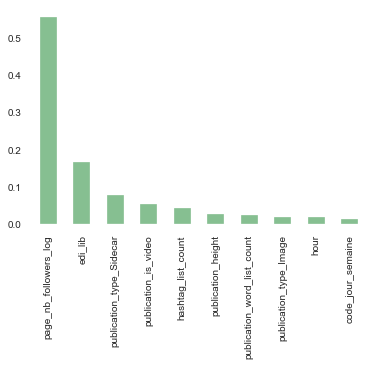

In [38]:
pd.Series(xgb_reg.feature_importances_, index=X_train.columns).nlargest(10).plot(kind='bar',color='#86bf91')

**Commentaires** : Le nombre de followers est la variable qui apporte le plus de poids à l'apprentissage du modèle. Puis la variable "edi_lib" qui correspond au type d'acteur (editeur ou libraire).

## 13) Découpage des heures en tranche d'heures
Lorsque je regarde le nb de like moyen par heure, je remarque qu'il y a des tranches d'actions. Une plutôt le matin, une autre à l'heure du repas-début d'après-midi, puis fin d'après-mi et enfin fin de soirée. les données statistiques vont en ce sens. C'est pourquoi je voudrais tester l'éventualité qu'un apprentissage suivant la tranche horaire est plus pertinente que simplement l'heure.

In [39]:
insta_ml = insta_ml.assign(tranche_horaire=insta_ml['hour'].map(lambda h: '0_11' if int(bin_f(h).hour) < 11 else (
    '11_15' if int(bin_f(h).hour) < 15 else ('15_18' if int(bin_f(h).hour) < 18 else '18_23'))))


In [40]:
insta_ml[['hour','tranche_horaire']].loc[insta_ml['hour']==12]


hour tranche_horaire
3        12           11_15
41       12           11_15
49       12           11_15
55       12           11_15
84       12           11_15
...     ...             ...
23171    12           11_15
23208    12           11_15
23213    12           11_15
23224    12           11_15
23245    12           11_15

[1923 rows x 2 columns]

Je relance mon modèle avec la nouvelle variable.

In [41]:
insta_ml_log = insta_ml_log.assign(tranche_horaire=insta_ml_log['hour'].map(lambda h: '0_11' if int(bin_f(h).hour) < 11 else (
    '11_15' if int(bin_f(h).hour) < 15 else ('15_18' if int(bin_f(h).hour) < 18 else '18_23'))))


In [42]:
insta_ml_log.head()

page_id              page_username           date_time       date  \
0  4741863243  librairielestempsmodernes 2017-03-09 22:16:32 2017-03-09   
1  4741863243  librairielestempsmodernes 2017-03-01 20:16:30 2017-03-01   
2  3655964171         librairielibellule 2019-10-11 16:56:30 2019-10-11   
3  3655964171         librairielibellule 2019-10-10 12:01:06 2019-10-10   
4  3655964171         librairielibellule 2019-08-31 18:55:53 2019-08-31   

   code_jour_semaine  day  month  year      time       publication_id  ...  \
0                  4    9      3  2017  22:16:32  1466950865096294144  ...   
1                  3    1      3  2017  20:16:30  1461092250598961920  ...   
2                  5   11     10  2019  16:56:30  2152397435142459904  ...   
3                  4   10     10  2019  12:01:06  2151523975361193472  ...   
4                  6   31      8  2019  18:55:53  2122741714331470080  ...   

                                        hashtag_list hashtag_list_count  \
0                                     pas de hashtag                  0   
1                                     pas de hashtag                  0   
2  [#librairie, #libellule, #librairieLibellule, ...                 21   
3  [#librairie, #libellule, #librairieLibellule, ...                 19   
4  [#librairie, #libellule, #librairieLibellule, ...                 17   

                               publication_word_list  \
0                                                      
1                                                      
2  [On, est, dans, la, place, au, Salon, "Lire, e...   
3  [Elle, est, là, !!, Sœur, Marie, Thérèse, est,...   
4  [C'est, la, rentrée, littéraire, !, C'est, le,...   

   publication_word_list_count  hour week_weekend  page_nb_followers  edi_lib  \
0                            0    22            0                218        1   
1                            0    20            0                218        1   
2                           41    16            0                236        1   
3                           22    12            0                236        1   
4                           25    18            1                236        1   

   page_nb_followers_log tranche_horaire  
0               5.389072           18_23  
1               5.389072           18_23  
2               5.468060           15_18  
3               5.468060           11_15  
4               5.468060           18_23  

[5 rows x 31 columns]

In [43]:
# y pour la Target
y_th= y #th==tranche horaire

X_th=insta_ml_log[['code_jour_semaine', 'tranche_horaire', 'publication_type', 'publication_height',
                   'publication_is_video', 'hashtag_list_count', 'publication_word_list_count'
                     ,'page_nb_followers_log', 'edi_lib']] 

#X_th[['page_nb_followers_log']]=X_th[['page_nb_followers']].apply(lambda x: np.log(x+1))
X_th['publication_is_video'] = np.where(X_th['publication_is_video']==True,1,0)
X_th = pd.get_dummies(X_th)
X_th.drop(columns=['publication_type_Video'], inplace=True)


X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_th,y_th ,train_size=0.80, test_size=0.20)

X_th_train.shape, X_th_test.shape, y_th_train.shape, y_th_test.shape

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



((18618, 13), (4655, 13), (18618,), (4655,))

In [44]:
xgb_reg = XGBRegressor(objective ='reg:squarederror', learning_rate=0.15, max_depth= 7,min_child_weight= 3,n_estimators = 150)
# fitting the model
xgb_reg.fit(X_th_train, y_th_train)

# predict the response
y_th_test_predict_xgb_reg = xgb_reg.predict(X_th_test)


R2_test =  round(r2_score(y_th_test, y_th_test_predict_xgb_reg),2)*100
R2_train = round(r2_score(y_th_train, xgb_reg.predict(X_th_train)),2)*100 
print('\nR2_score_train', R2_train, '\nR2_score_test', R2_test)

rmsle_test = np.sqrt(mean_squared_error(y_th_test, y_th_test_predict_xgb_reg))
rmsle_train = np.sqrt(mean_squared_error(y_th_train, xgb_reg.predict(X_th_train)))
print('\nrmse_score_train', rmsle_train, '\nrmse_score_test', rmsle_test)

real_rmse_test = np.sqrt(mean_squared_error(np.exp(y_th_test), np.exp(y_th_test_predict_xgb_reg)))
real_rmse_train = np.sqrt(mean_squared_error(np.exp(y_th_train), np.exp(xgb_reg.predict(X_th_train))))
print('\nreal_rmse_score_train', real_rmse_train, '\nreal_rmse_score_test', real_rmse_test)


R2_score_train 87.0 
R2_score_test 80.0

rmse_score_train 0.4318626797438654 
rmse_score_test 0.5526246942304651

real_rmse_score_train 159.01949660828788 
real_rmse_score_test 162.37744761101908


**Commentaire** : Le R2 score gagne 2 points d'apprentissage.

### ***########################################################***

## Engineering : Traitement des Emoji et NLP

## 14) Emoji
1) je crée une colonne qui répertorie les **émojis présents** dans les publications puis je crée une colonne qui indique le **nombre d'émojis** par publications.

In [45]:
import demoji
demoji.download_codes()

... OK (Got response in 0.32 seconds)
Writing emoji data to /Users/eleonore/.demoji/codes.json ...
... OK


In [46]:
dict_emoji2=[demoji.findall(text) for text in insta_ml['text_publication'] ]
list_of_emoj_temp = set([key for dico in dict_emoji2 for key, value in dico.items()] )

In [47]:
def countEmoji(publi):
    list_of_emoj=[hashtag for hashtag in re.sub(r"\w+", r"", publi).split() for h in hashtag if(h in list_of_emoj_temp)]
    return list_of_emoj

insta_ml = insta_ml.assign(emoji_list=insta_ml['text_publication'].map(lambda text: countEmoji(text) ))
insta_ml = insta_ml.assign(emoji_count=insta_ml['emoji_list'].map(lambda emo: len(emo)))
insta_ml.drop(columns=['emoji_list'], inplace=True)

## 15) Sentiment
Polarité et Subjectivité

In [48]:
def clean_up(s):
    """ Cleans up numbers, URLs, and special characters from a string."""
    
    list_to_sub=['\d','https?:\/\/.*[\d]*','http?:\/\/.*[\d]*','@','\W','www']
    
    """ Args: s: The string to be cleaned up."""
    for exp in list_to_sub:
        s= re.sub(exp, r' ', s).lower()

    """ Returns: A string that has been cleaned up."""
    return(s)

In [49]:
from textblob import TextBlob

def sentiment(publi):
    publi = clean_up(publi)
    polarity=TextBlob(publi).polarity
    subjectivity=TextBlob(publi).subjectivity
    return polarity, subjectivity  

In [50]:
insta_ml= insta_ml.assign(publication_polarity = insta_ml['text_publication'].map(lambda publi : sentiment(publi)[0]))
insta_ml= insta_ml.assign(publication_subjectivity = insta_ml['text_publication'].map(lambda publi : sentiment(publi)[1]))


In [51]:
#insta_ml['text_publication'][23257]

In [52]:
#POUR SAUVEGARDE REGULIERE
insta_ml.to_json('BACKUP/insta_ML_EMOJI_SENTIMENT-BACKUP.json', orient='records')
#POUR GITHUB
insta_ml.to_csv('BACKUP/projet_ironhack_insta_final.csv', index=False)

#POUR SAUVEGARDE pour Datavisualisation TABLEAU
insta_ml.to_csv('BACKUP/insta_avec_follower_final-BACKUP.csv', index=False)
    #Enregistrer ce fichier de script

## 16) ML avec les nouvelles variables

In [53]:
insta_ml_feat=insta_ml.copy()

insta_ml_feat.columns

Index(['page_id', 'page_username', 'date_time', 'date', 'code_jour_semaine',
       'day', 'month', 'year', 'time', 'publication_id', 'publication_type',
       'text_publication', 'publication_liked_count', 'publication_height',
       'publication_width', 'publication_url', 'publication_comment_count',
       'publication_video_view_count', 'publication_is_video',
       'publication_shortcode', 'publication_thumbnail_src', 'hashtag_list',
       'hashtag_list_count', 'publication_word_list',
       'publication_word_list_count', 'hour', 'week_weekend',
       'page_nb_followers', 'edi_lib', 'tranche_horaire', 'emoji_count',
       'publication_polarity', 'publication_subjectivity'],
      dtype='object')

In [54]:
X_feat=insta_ml_feat[['code_jour_semaine', 'tranche_horaire', 'publication_type', 'publication_height',
                   'publication_is_video', 'hashtag_list_count', 'publication_word_list_count'
                     ,'page_nb_followers', 'emoji_count',
                   'edi_lib','publication_polarity', 'publication_subjectivity']] 

X_feat['page_nb_followers_log']=X_feat['page_nb_followers'].apply(lambda x: np.log(x+1))
X_feat['publication_is_video'] = np.where(X_feat['publication_is_video']==True,1,0)
X_feat = pd.get_dummies(X_feat)
X_feat.drop(columns=['publication_type_Video','page_nb_followers'], inplace=True)

y_feat= insta_ml["publication_liked_count"]
y_feat=y_feat.apply(lambda x: np.log(x+1))

X_feat.columns

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Index(['code_jour_semaine', 'publication_height', 'publication_is_video',
       'hashtag_list_count', 'publication_word_list_count', 'emoji_count',
       'edi_lib', 'publication_polarity', 'publication_subjectivity',
       'page_nb_followers_log', 'tranche_horaire_0_11',
       'tranche_horaire_11_15', 'tranche_horaire_15_18',
       'tranche_horaire_18_23', 'publication_type_Image',
       'publication_type_Sidecar'],
      dtype='object')

In [55]:
## Split
X_feat_train, X_feat_test, y_feat_train, y_feat_test = train_test_split(X_feat,y_feat ,train_size=0.80, test_size=0.20)

X_feat_train.shape, X_feat_test.shape, y_feat_train.shape, y_feat_test.shape

((18618, 16), (4655, 16), (18618,), (4655,))

In [56]:
xgb_reg_feat = XGBRegressor(objective ='reg:squarederror', learning_rate=0.15, max_depth= 7,min_child_weight= 3,n_estimators = 150)

# fitting the model
xgb_reg_feat.fit(X_feat_train, y_feat_train)

# predict the response
y_feat_test_predict_xgb_reg = xgb_reg_feat.predict(X_feat_test)


R2_test =  round(r2_score(y_feat_test, y_feat_test_predict_xgb_reg),2)*100
R2_train = round(r2_score(y_feat_train, xgb_reg_feat.predict(X_feat_train)),2)*100 
print('\nR2_score_train', R2_train, '\nR2_score_test', R2_test)

rmsle_test = np.sqrt(mean_squared_error(y_feat_test, y_feat_test_predict_xgb_reg))
rmsle_train = np.sqrt(mean_squared_error(y_feat_train, xgb_reg_feat.predict(X_feat_train)))
print('\nrmse_score_train', rmsle_train, '\nrmse_score_test', rmsle_test)

real_rmse_test = np.sqrt(mean_squared_error(np.exp(y_feat_test), np.exp(y_feat_test_predict_xgb_reg)))
real_rmse_train = np.sqrt(mean_squared_error(np.exp(y_feat_train), np.exp(xgb_reg_feat.predict(X_feat_train))))
print('\nreal_rmse_score_train', real_rmse_train, '\nreal_rmse_score_test', real_rmse_test)


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version




R2_score_train 87.0 
R2_score_test 79.0

rmse_score_train 0.4280701746228697 
rmse_score_test 0.5602332919138915

real_rmse_score_train 146.35455365834815 
real_rmse_score_test 182.51410277255331


**Comentaire** : Amélioration du R2 score de 1 point et RMSE légèrement meilleur en cmparaison à l'apprentissage sans feature engineering (c'est à dire hors `tranche horaire`).

### Features importance final.

In [57]:
print('\nFeature_importances:\n', dict(zip(X_feat.columns,xgb_reg_feat.fit(X_feat_train, y_feat_train).feature_importances_)))

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version




Feature_importances:
 {'code_jour_semaine': 0.015791362, 'publication_height': 0.027581738, 'publication_is_video': 0.07523174, 'hashtag_list_count': 0.036947872, 'publication_word_list_count': 0.021944532, 'emoji_count': 0.030605078, 'edi_lib': 0.15950902, 'publication_polarity': 0.01748711, 'publication_subjectivity': 0.01761703, 'page_nb_followers_log': 0.45268866, 'tranche_horaire_0_11': 0.015544656, 'tranche_horaire_11_15': 0.02111047, 'tranche_horaire_15_18': 0.0154376915, 'tranche_horaire_18_23': 0.020488644, 'publication_type_Image': 0.01327696, 'publication_type_Sidecar': 0.058737416}


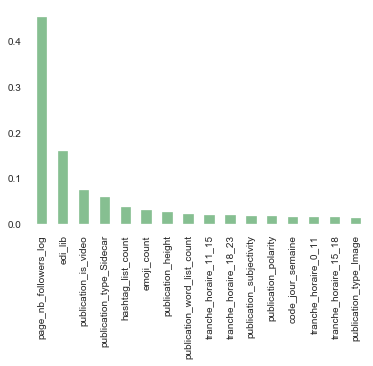

In [58]:
pd.Series(xgb_reg_feat.feature_importances_, index=X_feat_train.columns).nlargest(20).plot(kind='bar',color='#86bf91')

### ***########################################################***
### Top 20 emoji

In [59]:
comment_emoji = ' '
bag_emoji=[]
for elem in dict_emoji2:
    for key,value in elem.items():
        comment_emoji = comment_emoji+value+','
        bag_emoji.append(value)

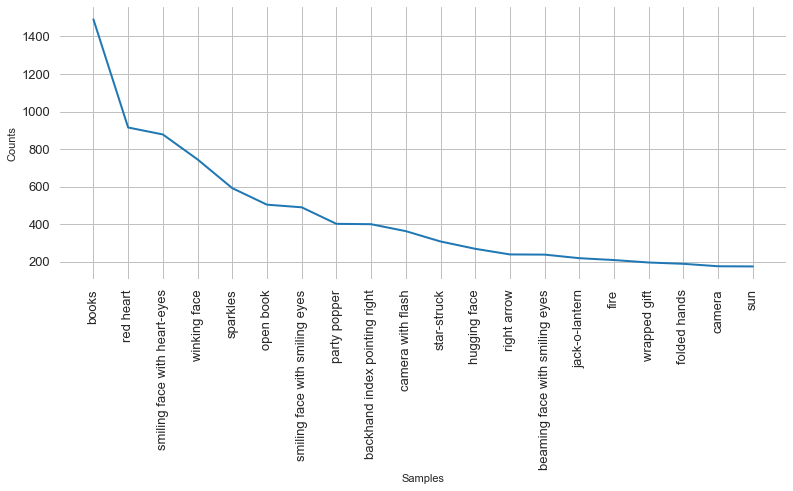

In [60]:
from nltk.probability import FreqDist

fdist_emoji = FreqDist(emoji for emoji in bag_emoji)
 
#for key,val in fdist_emoji.items():
 #   print (str(key) + ':' + str(val))
    
plt.figure(figsize=(13,5))
plt.tick_params(labelsize=13)
fdist_emoji.plot(20, cumulative=False)


### Nuage de mots

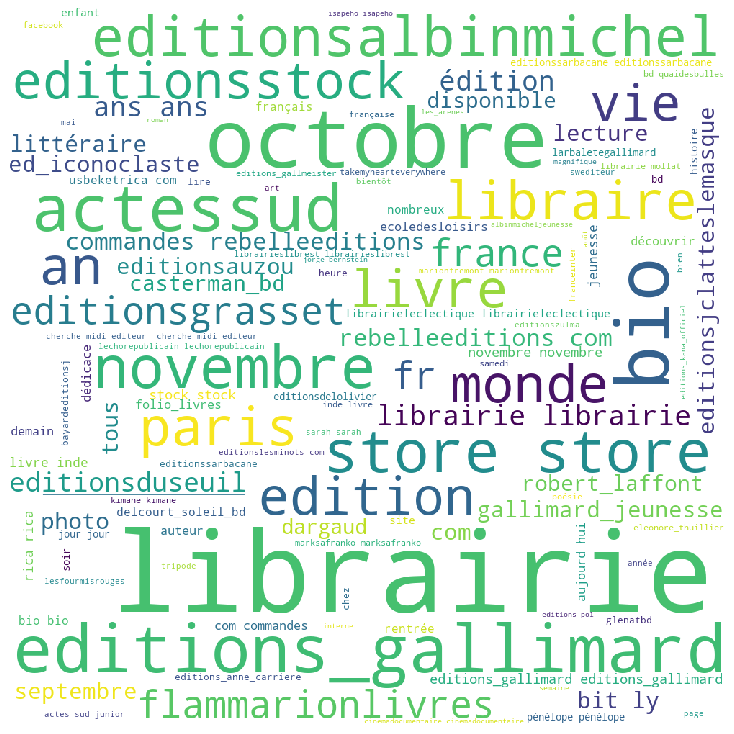

In [63]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords

stopwords = stopwords.words('french')
#ajout de 2 mots
stopwords.append("très")
stopwords.append("être")

comment_words = ' ' #We will be appending the words to this var
for list_word in insta_ml_feat.publication_word_list:
    for word in list_word:
        word=clean_up(word)
    comment_words = comment_words + word + ' '
    
wordcloud=WordCloud(width=1000,height=1000, background_color='white', stopwords=stopwords,min_font_size=10).generate(comment_words)

plt.figure(figsize=(10,10),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### ***########################################################***
### Top 20 hashtag

In [64]:
comment_hashtag = [] #We will be appending the words to this var
for list_hashtag in insta_ml_feat.hashtag_list:
    if list_hashtag != 'pas de hashtag':
        for hashtag in list_hashtag:
            comment_hashtag.append(hashtag)

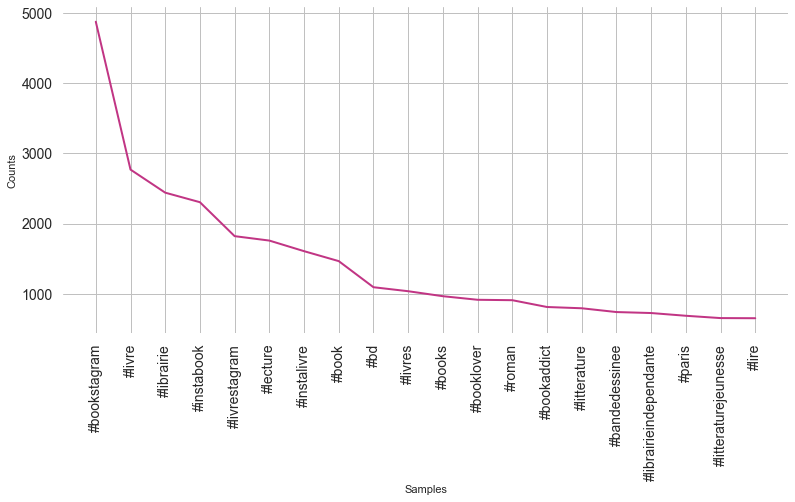

In [65]:
fdist_hashtag = FreqDist(hashtag for hashtag in comment_hashtag)
 
#for key,val in fdist_emoji.items():
 #   print (str(key) + ':' + str(val))
    
plt.figure(figsize=(13,6))
plt.tick_params(labelsize=14)
fdist_hashtag.plot(20, cumulative=False, color='#c13584')


### ***########################################################***
### PICKLE

In [66]:
import pickle

# save the model to disk
filename = 'finalized_model.pickle'
pickle.dump(xgb_reg_feat, open(filename, 'wb'))


In [70]:
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_feat_test, y_feat_test)
print(round(result*100))

79.0


In [ ]:
"""xgb_reg_feat_final = XGBRegressor(objective ='reg:squarederror', learning_rate=0.15, max_depth=4,min_child_weight=7,n_estimators = 885)

# fitting the model
xgb_reg_feat_final.fit(X_feat_train, y_feat_train)

# predict the response
y_feat_test_predict_xgb_reg = xgb_reg_feat_final.predict(X_feat_test)


R2_test =  round(r2_score(y_feat_test, y_feat_test_predict_xgb_reg),5)*100
R2_train = round(r2_score(y_feat_train, xgb_reg_feat_final.predict(X_feat_train)),2)*100 
print('\nR2_score_train', R2_train, '\nR2_score_test', R2_test)

rmsle_test = np.sqrt(mean_squared_error(y_feat_test, y_feat_test_predict_xgb_reg))
rmsle_train = np.sqrt(mean_squared_error(y_feat_train, xgb_reg_feat_final.predict(X_feat_train)))
print('\nrmse_score_train', rmsle_train, '\nrmse_score_test', rmsle_test)

real_rmse_test = np.sqrt(mean_squared_error(np.exp(y_feat_test), np.exp(y_feat_test_predict_xgb_reg)))
real_rmse_train = np.sqrt(mean_squared_error(np.exp(y_feat_train), np.exp(xgb_reg_feat_final.predict(X_feat_train))))
print('\nreal_rmse_score_train', real_rmse_train, '\nreal_rmse_score_test', real_rmse_test)"""
